In [ ]:
# Imports
!pip install tf_keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 75.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.3-py3-none-any.whl size=25316960 sha256=6a535740778d87b6e449ee9fe02684cd0990f8de520aa3f20d0e759972b627e9
  Stored in directory: /root/.cache/pip/wheels/fc/76/11/5b953090eebf531f660948a30cd26e70260619f6480f186a5a
  Created wheel for keras_bert: filename=

In [ ]:
# check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  6 01:23:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
reviews = pd.read_json("/content/drive/MyDrive/MSDS_marketing_text_analytics/article_categories.json")

In [ ]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Exploratory Data Analsis

In [ ]:
reviews['category'].value_counts()

category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: c

In [ ]:
# reviews['health-wellness'] = np.where((reviews['category'] in ['HEALTHY LIVING', 'WELLNESS']), 1, 0)
reviews['health-wellness'] = np.where(reviews['category'].isin(['HEALTHY LIVING', 'WELLNESS']), 1, 0)
reviews['health-wellness'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: health-wellness, dtype: float64

With counts ranging from 1004 to 32,739, we can see the dataset skews heavily towards samples from the "Politics" category, which makes sense given HuffPost's coverage. Since this project is focusing on identifying health or wellness articles, I have added a column to represent the response as 1 or 0, 1 being a positive sample.

Based on the distribution of this column, our dataset includes about 12% positive examples and 88% negative examples. We will want to balance this so as to not skew the resulting accuracy.

### Checking for potential data cleaning

In [ ]:
reviews.isnull().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
health-wellness      0
dtype: int64

In [ ]:
reviews['short_description'].str.len().describe()

count    200853.000000
mean        114.312686
std          82.288156
min           0.000000
25%          57.000000
50%         120.000000
75%         133.000000
max        1472.000000
Name: short_description, dtype: float64

"short_description" can very dramatically in length! It might be best to trim the outliers exceeding 1000 chars.

<Axes: xlabel='year'>

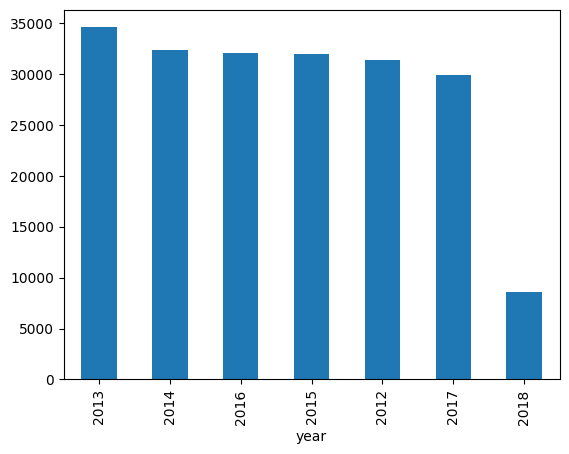

In [ ]:
reviews['year'] = pd.to_datetime(reviews['date']).dt.year
reviews['year'].value_counts().plot(kind='bar')

## Data Preprocessing

We need to process our text into tokens that are usable by a model.

In [ ]:
reviews[reviews['health-wellness'] == 1].count()

category             24521
headline             24521
authors              24521
link                 24521
short_description    24521
date                 24521
health-wellness      24521
dtype: int64

In [ ]:
sample_amount = 10000
positive = reviews[reviews['health-wellness'] == 1].sample(n=sample_amount)
negative = reviews[reviews['health-wellness'] == 0].sample(n=sample_amount)
reviews_subset = pd.concat([positive,negative])
# shuffle after concatenating
reviews_subset = reviews_subset.sample(frac=1).reset_index(drop=True)

Prepare the text for Distillbert tokenization.

In [ ]:
# Include headline, and trim excessively long descriptions
# Truncate 'short_description' to be no longer than 500 characters
reviews_subset['short_description'] = reviews_subset['short_description'].str.slice(0, 512)
reviews_subset['text'] = reviews_subset['headline'] + ' ' + reviews_subset['short_description']

In [ ]:
train, val, preprocess = ktrain.text.texts_from_df(
    reviews_subset,
    "text",
    label_columns=["health-wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
19564                  0.0              1.0
5143                   0.0              1.0
9432                   1.0              0.0
3715                   1.0              0.0
20                     0.0              1.0
['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
10308                  1.0              0.0
16542                  1.0              0.0
17624                  0.0              1.0
6781                   1.0              0.0
14542                  0.0              1.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=64)

In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
562/562 [==============================] - 271s 402ms/step - loss: 0.6333 - accuracy: 0.6753
Epoch 2/6
562/562 [==============================] - 229s 408ms/step - loss: 0.2759 - accuracy: 0.8926
Epoch 3/6
562/562 [==============================] - 228s 406ms/step - loss: 0.3333 - accuracy: 0.8414
Epoch 4/6
562/562 [==============================] - 227s 404ms/step - loss: 0.6997 - accuracy: 0.4983
Epoch 5/6
562/562 [==============================] - 226s 401ms/step - loss: 0.6968 - accuracy: 0.4952
Epoch 6/6
562/562 [==============================] - 58s 102ms/step - loss: 920.1299 - accuracy: 0.4991


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


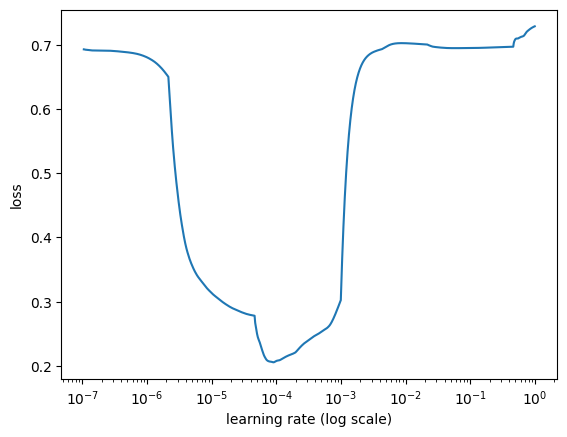

In [ ]:
learner.lr_plot()

In [ ]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
282/282 [==============================] - 252s 810ms/step - loss: 0.2915 - accuracy: 0.8840 - val_loss: 0.2237 - val_accuracy: 0.9080
Epoch 2/10
282/282 [==============================] - 221s 784ms/step - loss: 0.1403 - accuracy: 0.9499 - val_loss: 0.2275 - val_accuracy: 0.9115
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

63/63 [==============================] - 6s 40ms/step
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       979
           1       0.90      0.92      0.91      1021

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



Save model for reproducibility and use:

In [ ]:
predictor.save('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-1-distilbert')

## Training Efficiency and Hardware

Training efficiency is about more than just patience, being able to train a full model in a manageable amount of time on accessible hardware makes replication more accessible and allows for more iteration on the model

The initial configuration using the unbalanced dataset with 200,853 samples on a T4 GPU resulted in ~3 hours of training per epoch, which would take a full day to complete training. Ultimately it was killed by Google Colab for running too long:



The balanced dataset with 24,521 samples per category (49,042 total) training on an L4 GPU performed better, mostly due to the reduction in the dataset. It was taking about 25min per epoch:

## Alternate Preprocessing

In the first model I used preprocess_mode="distilbert"

During inference, DistilBERT is 60% faster than BERT. DistilBERT has 44M fewer parameters and in total is 40% smaller than BERT. DistilBERT retains 97% of BERT performance

In [ ]:
# release GPU memory for next training
ktrain.release_gpu_memory()

In [ ]:
train_bert, val_bert, preprocess_bert = ktrain.text.texts_from_df(
    reviews_subset,
    "text",
    label_columns=["health-wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="bert",
    verbose=1
)

['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
13205                  1.0              0.0
9977                   0.0              1.0
17191                  1.0              0.0
8294                   1.0              0.0
7482                   0.0              1.0
['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
13581                  0.0              1.0
19951                  1.0              0.0
2255                   1.0              0.0
4410                   0.0              1.0
3895                   0.0              1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
# model_bert = preprocess_bert.get_classifier()
model_bert = ktrain.text.text_classifier(name='bert', train_data=train_bert, preproc=preprocess_bert)
learner_bert = ktrain.get_learner(model_bert, train_data=train_bert, val_data=val_bert, batch_size=16)

Is Multi-Label? False
maxlen is 512


/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


/usr/local/lib/python3.10/dist-packages/ktrain/__init__.py:100: UserWarning: For a GPU with 12GB of RAM, the following maxima apply:
        sequence len=64, max_batch_size=64
        sequence len=128, max_batch_size=32
        sequence len=256, max_batch_size=16
        sequence len=320, max_batch_size=14
        sequence len=384, max_batch_size=12
        sequence len=512, max_batch_size=6

        You've exceeded these limits.
        If using a GPU with <=12GB of memory, you may run out of memory during training.
        If necessary, adjust sequence length or batch size based on above.
  I.warnings.warn(msg)


In [ ]:
history_bert = learner_bert.autofit(
    1e-4,
    checkpoint_folder='checkpoint_b',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
1125/1125 [==============================] - 607s 498ms/step - loss: 0.2902 - accuracy: 0.8804 - val_loss: 0.2100 - val_accuracy: 0.9150
Epoch 2/10
1125/1125 [==============================] - 551s 490ms/step - loss: 0.1618 - accuracy: 0.9394 - val_loss: 0.2351 - val_accuracy: 0.9150
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor_bert = ktrain.get_predictor(learner_bert.model, preproc=preprocess_bert)
validation_bert = learner_bert.validate(val_data=val_bert, print_report=True)

63/63 [==============================] - 26s 282ms/step
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       965
           1       0.90      0.94      0.92      1035

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.91      2000



In [ ]:
predictor_bert.save('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-2-bert')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Alternate Preprocessing: Larger N-grams, Less Text

During the preprocessing step, I expanded the text representation to include up to trigrams (3-grams) to capture more contextual information from the text. To accommodate the increased number of features resulting from the inclusion of trigrams, I increased the max_features parameter, ensuring that the model can handle a larger vocabulary size effectively. Additionally, recognizing that the expanded feature space might lead to more complex training dynamics, I decreased the learning rate to help the model converge more smoothly and prevent potential issues with overshooting during optimization.

In [ ]:
train_data_c, val_data_c, preprocess_c = ktrain.text.texts_from_df(
    reviews_subset,
    "text",
    label_columns=["health-wellness"],
    val_df=None,
    max_features=40000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=3,
    preprocess_mode="distilbert",
    verbose=1
)

model_c = preprocess_c.get_classifier()
learner_c = ktrain.get_learner(model_c, train_data=train_data_c, val_data=val_data_c, batch_size=32)

['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
2946                   1.0              0.0
11011                  0.0              1.0
15720                  0.0              1.0
2801                   1.0              0.0
2618                   1.0              0.0
['not_health-wellness', 'health-wellness']
       not_health-wellness  health-wellness
7006                   0.0              1.0
12141                  0.0              1.0
12898                  0.0              1.0
12166                  1.0              0.0
3500                   0.0              1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 57
	99percentile : 68


In [ ]:
history_c = learner_c.autofit(
    1e-5,
    checkpoint_folder='checkpoint_larger_ngrams',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/10
563/563 [==============================] - 259s 418ms/step - loss: 0.3081 - accuracy: 0.8718 - val_loss: 0.2082 - val_accuracy: 0.9240
Epoch 2/10
563/563 [==============================] - 230s 409ms/step - loss: 0.1865 - accuracy: 0.9308 - val_loss: 0.2100 - val_accuracy: 0.9185
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor_c = ktrain.get_predictor(learner_c.model, preproc=preprocess_c)
validation_c = learner_c.validate(val_data=val_data_c, print_report=True)

63/63 [==============================] - 6s 42ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1008
           1       0.92      0.93      0.92       992

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
predictor_c.save('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-3-ngrams-512')

## Evaluation

First let's take a qualitative

In [ ]:
# Reload models if needed
predictor = ktrain.load_predictor('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-1-distilbert')
# predictor_bert = ktrain.load_predictor('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-2-bert')
# predictor_c = ktrain.load_predictor('/content/drive/MyDrive/MSDS_marketing_text_analytics/model-3-ngrams-512')

In [ ]:
samples = reviews_subset.sample(10)

# Model A: Distilbert Based
for text in samples['text']:
    probs = predictor.predict(text, return_proba=True)
    print("---------------------------")
    print('The probability this is health/wellness is %s' % probs[1])
    print(text)

NameError: name 'sampled_reviews' is not defined

In [ ]:
# Model B: Bert Based
for text in samples['text']:
    probs = predictor_bert.predict(text, return_proba=True)
    print("---------------------------")
    print('The probability this is health/wellness is %s' % probs[1])
    print(text)

---------------------------
The probability this is health/wellness is 0.98177713
On the To-Do List: Watch for Moments of Transcendence In the rush of our daily routines, it's so easy to miss moments of transcendence. In art, they are masterfully presented, with language and emphasis that set them apart like jewels. In ordinary life, they rush by. I try to remind myself to look for them every day.
---------------------------
The probability this is health/wellness is 0.984327
Rare and Precious Joy Begin by remembering to pause and savor the simple pleasures. Have the intention to hold gently the difficulties. Open your heart to the life of this moment and discover that joy is never very far away.
---------------------------
The probability this is health/wellness is 0.00050845527
National Security Vets Warn Court That Donald Trump's Travel Ban Threatens Country “We view the Order as one that ultimately undermines the national security of the United States, rather than making us safer."

In [ ]:
# Model C: Larger N-gram Distilbert
for text in samples['text']:
    probs = predictor_c.predict(text, return_proba=True)
    print("---------------------------")
    print('The probability this is health/wellness is %s' % probs[1])
    print(text)

precision

recall

f1-score

support

In [ ]:
import matplotlib.pyplot as plt

# Static metric variables for reference
categories = ['Precision', 'Recall', 'F1-score', 'Support (thousands)']
model_a = [0.91, 0.91, 0.91, 2000/2000]
model_b = [0.92, 0.92, 0.91, 2000/2000]
model_c = [0.92, 0.92, 0.92, 2000/2000]
model_vargo = [0.86, 0.86, 0.86, 1339/2000]

# Plot to compare
n_categories = len(categories)
bar_width = 0.2
r1 = np.arange(n_categories)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(10, 5))
plt.bar(r1, model_a, color='#1abc9c', width=bar_width, label='Model A (Distilbert)')
plt.bar(r2, model_b, color='#e67e22', width=bar_width, label='Model B (Bert)')
plt.bar(r3, model_c, color='#9b59b6', width=bar_width, label='Model C (Distilbert, trigrams)')
plt.bar(r4, model_vargo, color='#3498db', width=bar_width, label='Model Baseline (Prof Vargo)')

# Set up with labels, legend, etc
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Model Comparison', fontweight='bold')
plt.xticks([r + 1.5 * bar_width for r in range(n_categories)], categories)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid(True)
plt.show()

NameError: name 'np' is not defined